In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from datetime import datetime
import humanfriendly
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

%matplotlib inline

- Загрузить файл <font color=blue>data_breast.csv</font>. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной “Diagnosis” - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” –malicious). Описание данных доступно на [сайте](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

Attribute Information:

1. ID number 
* Diagnosis (M = malignant, B = benign) 


Ten real-valued features are computed for each cell nucleus: 
3. radius (mean of distances from center to points on the perimeter) 
* texture (standard deviation of gray-scale values) 
* perimeter 
* area 
* smoothness (local variation in radius lengths) 
* compactness (perimeter^2 / area - 1.0) 
* concavity (severity of concave portions of the contour) 
* concave points (number of concave portions of the contour) 
* symmetry 
* fractal dimension ("coastline approximation" - 1)

In [2]:
data = pd.read_csv("data_breast.csv")

In [3]:
parameter_names = ["radius", "texture", "perimeter", "area", "smoothness",
            "compactness", "concavity", "concave points", "symmetry", "fractal_dimension"]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

In [5]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


в таблице есть столбец не содержащий никаких значений, удалим его

In [6]:
data.drop('Unnamed: 32', axis=1, inplace=True)

- Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).

In [7]:
data.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


посмотрим распределения значений

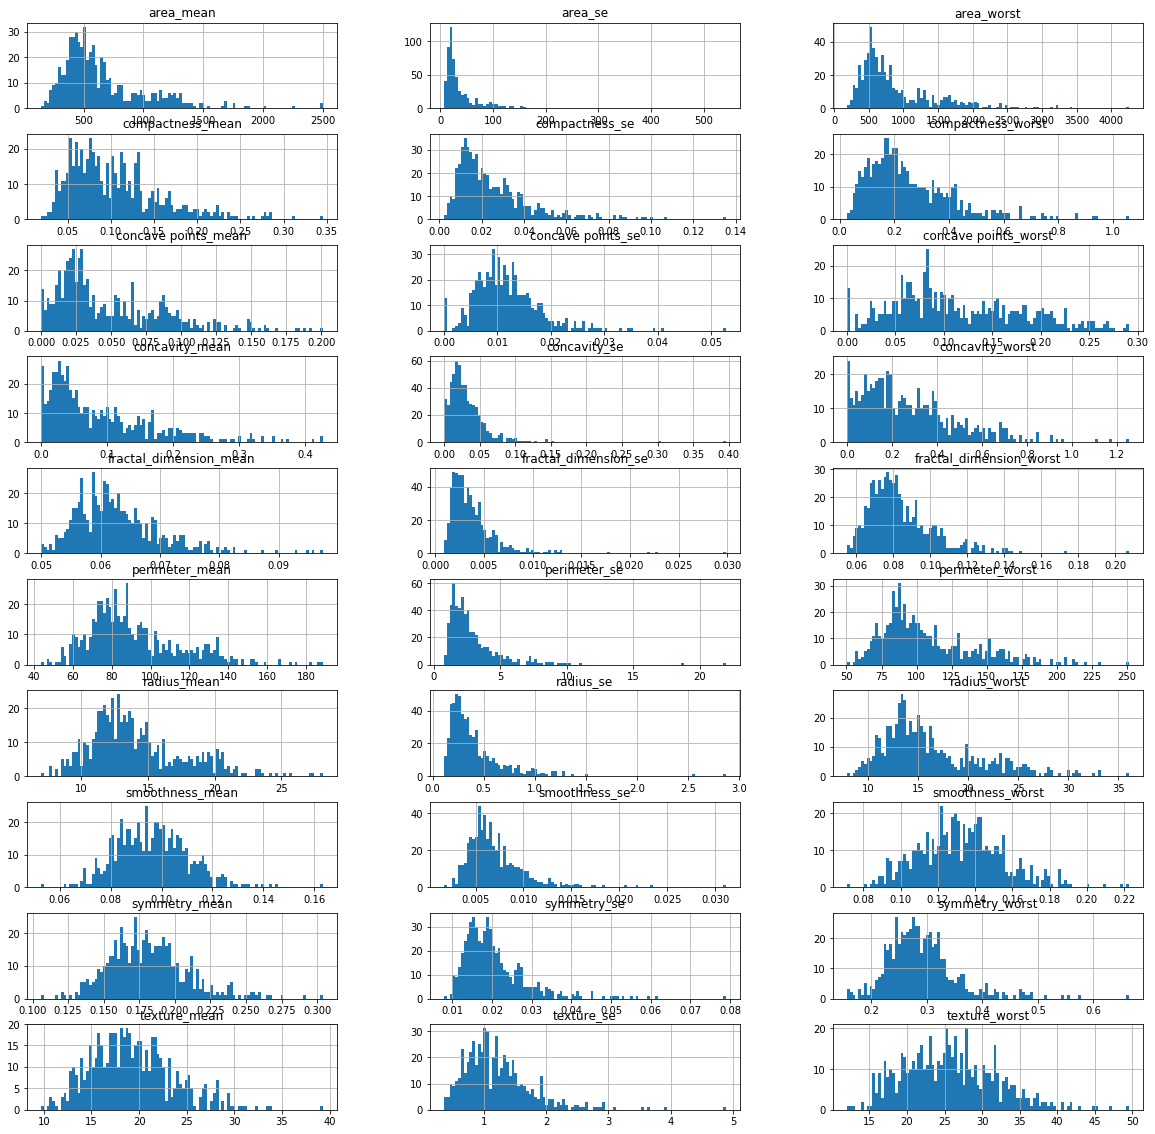

In [8]:

data.hist(bins=100, figsize=(20,20), column=[c for c in data.columns if c != 'id'], layout=(10,3))
plt.show()

- Выбрать стратегию для работы с пропущенными значениями.

пропущенных значений в таблице нет

- Рассчитать и визуализировать корреляционную матрицу для переменных.

перегруппируем столбцы чтобы стобцы mean, se и worst были рядом

In [9]:
def get_columns(postfixes):
    l = list([i[0] + "_" + i[1] for i in itertools.product(parameter_names, postfixes)])
    l.append("diagnosis")
    return l

In [10]:
# corr_mtx = data[get_all_columns()].corr()
corr_mtx = data[get_columns(["mean", "se", "worst"])].corr()

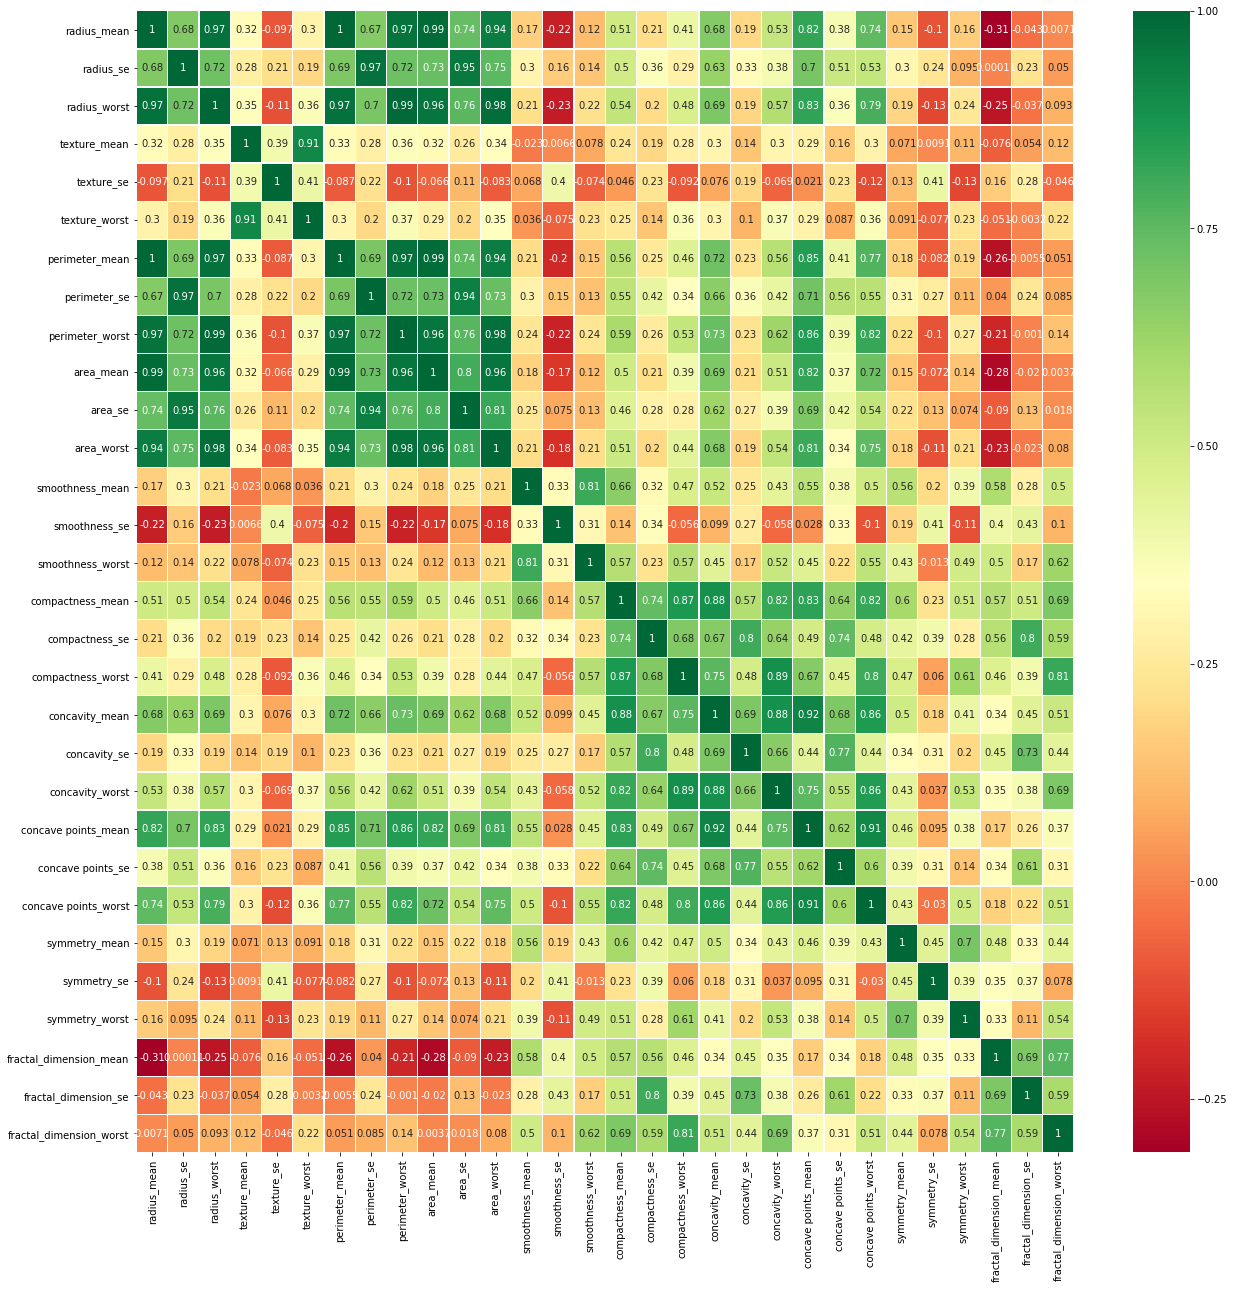

In [11]:
sns.heatmap(corr_mtx, annot = True, cmap = "RdYlGn", robust = False, \
            xticklabels=True, yticklabels=True, linewidths=0.2)
fig = plt.gcf()
fig.set_size_inches(21,21)
plt.show()

посмотрим как коррелирует один и тот же параметр в разных группах

In [12]:
index_pairs = [("mean", "se"), ("mean", "worst"), ("se", "worst")]
# corr_mtx
d = {x : [corr_mtx[x + "_" + y[0]][x + "_" + y[1]] for y in index_pairs] for x in parameter_names}
i = [x[0] + " -> " + x[1] for x in index_pairs]
pd.DataFrame(data = d, index = i)

,radius,texture,perimeter,area,smoothness,compactness,concavity,concave points,symmetry,fractal_dimension
mean -> se,0.679090,0.386358,0.693135,0.800086,0.332375,0.738722,0.691270,0.615634,0.449137,0.688132
mean -> worst,0.969539,0.912045,0.970387,0.959213,0.805324,0.865809,0.884103,0.910155,0.699826,0.767297
se -> worst,0.715065,0.409003,0.721031,0.811408,0.314457,0.678780,0.662564,0.602450,0.389402,0.591328


очень сильная корреляция параметров между группами mean и worst

- Визуализировать взаимосвязи между переменными (scatter plots, гистограммы, …).

так как у нас три блока одних и тех же переменных то мы можем посмотреть корреляцию друг с другом среди одной группы напеример **mean**

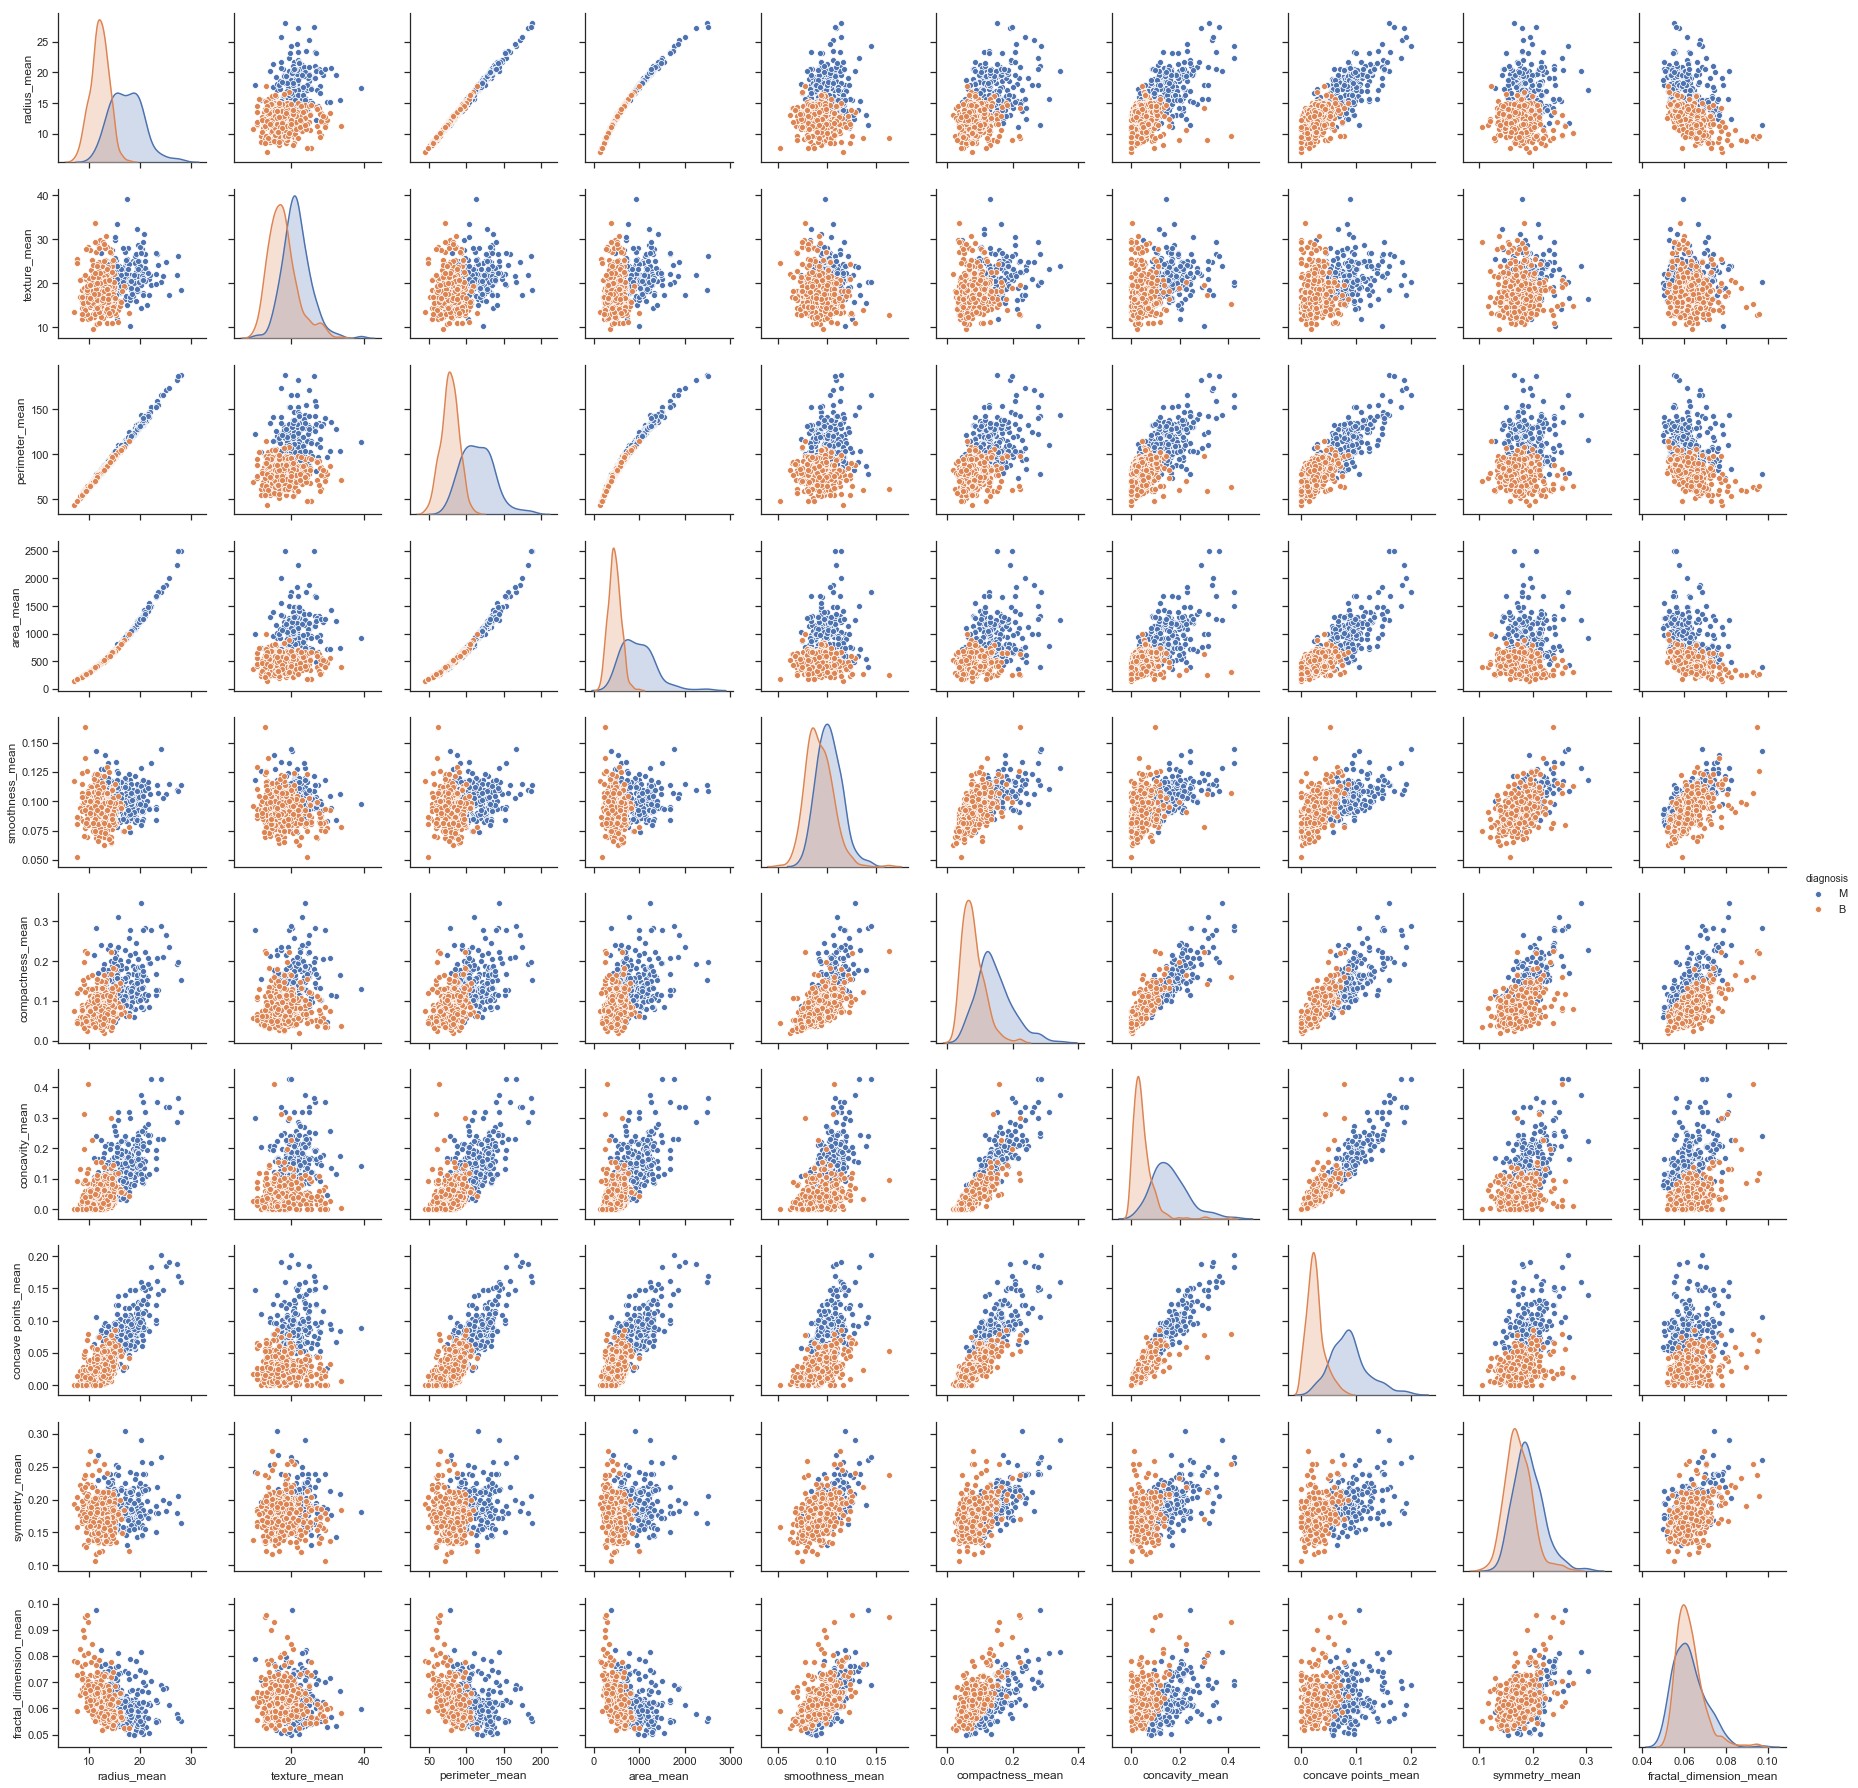

In [13]:
sns.set(style="ticks", color_codes=True)
grid = sns.pairplot(data=data[get_columns(["mean"])], hue='diagnosis')
plt.show()

повторяем для для группы **se**

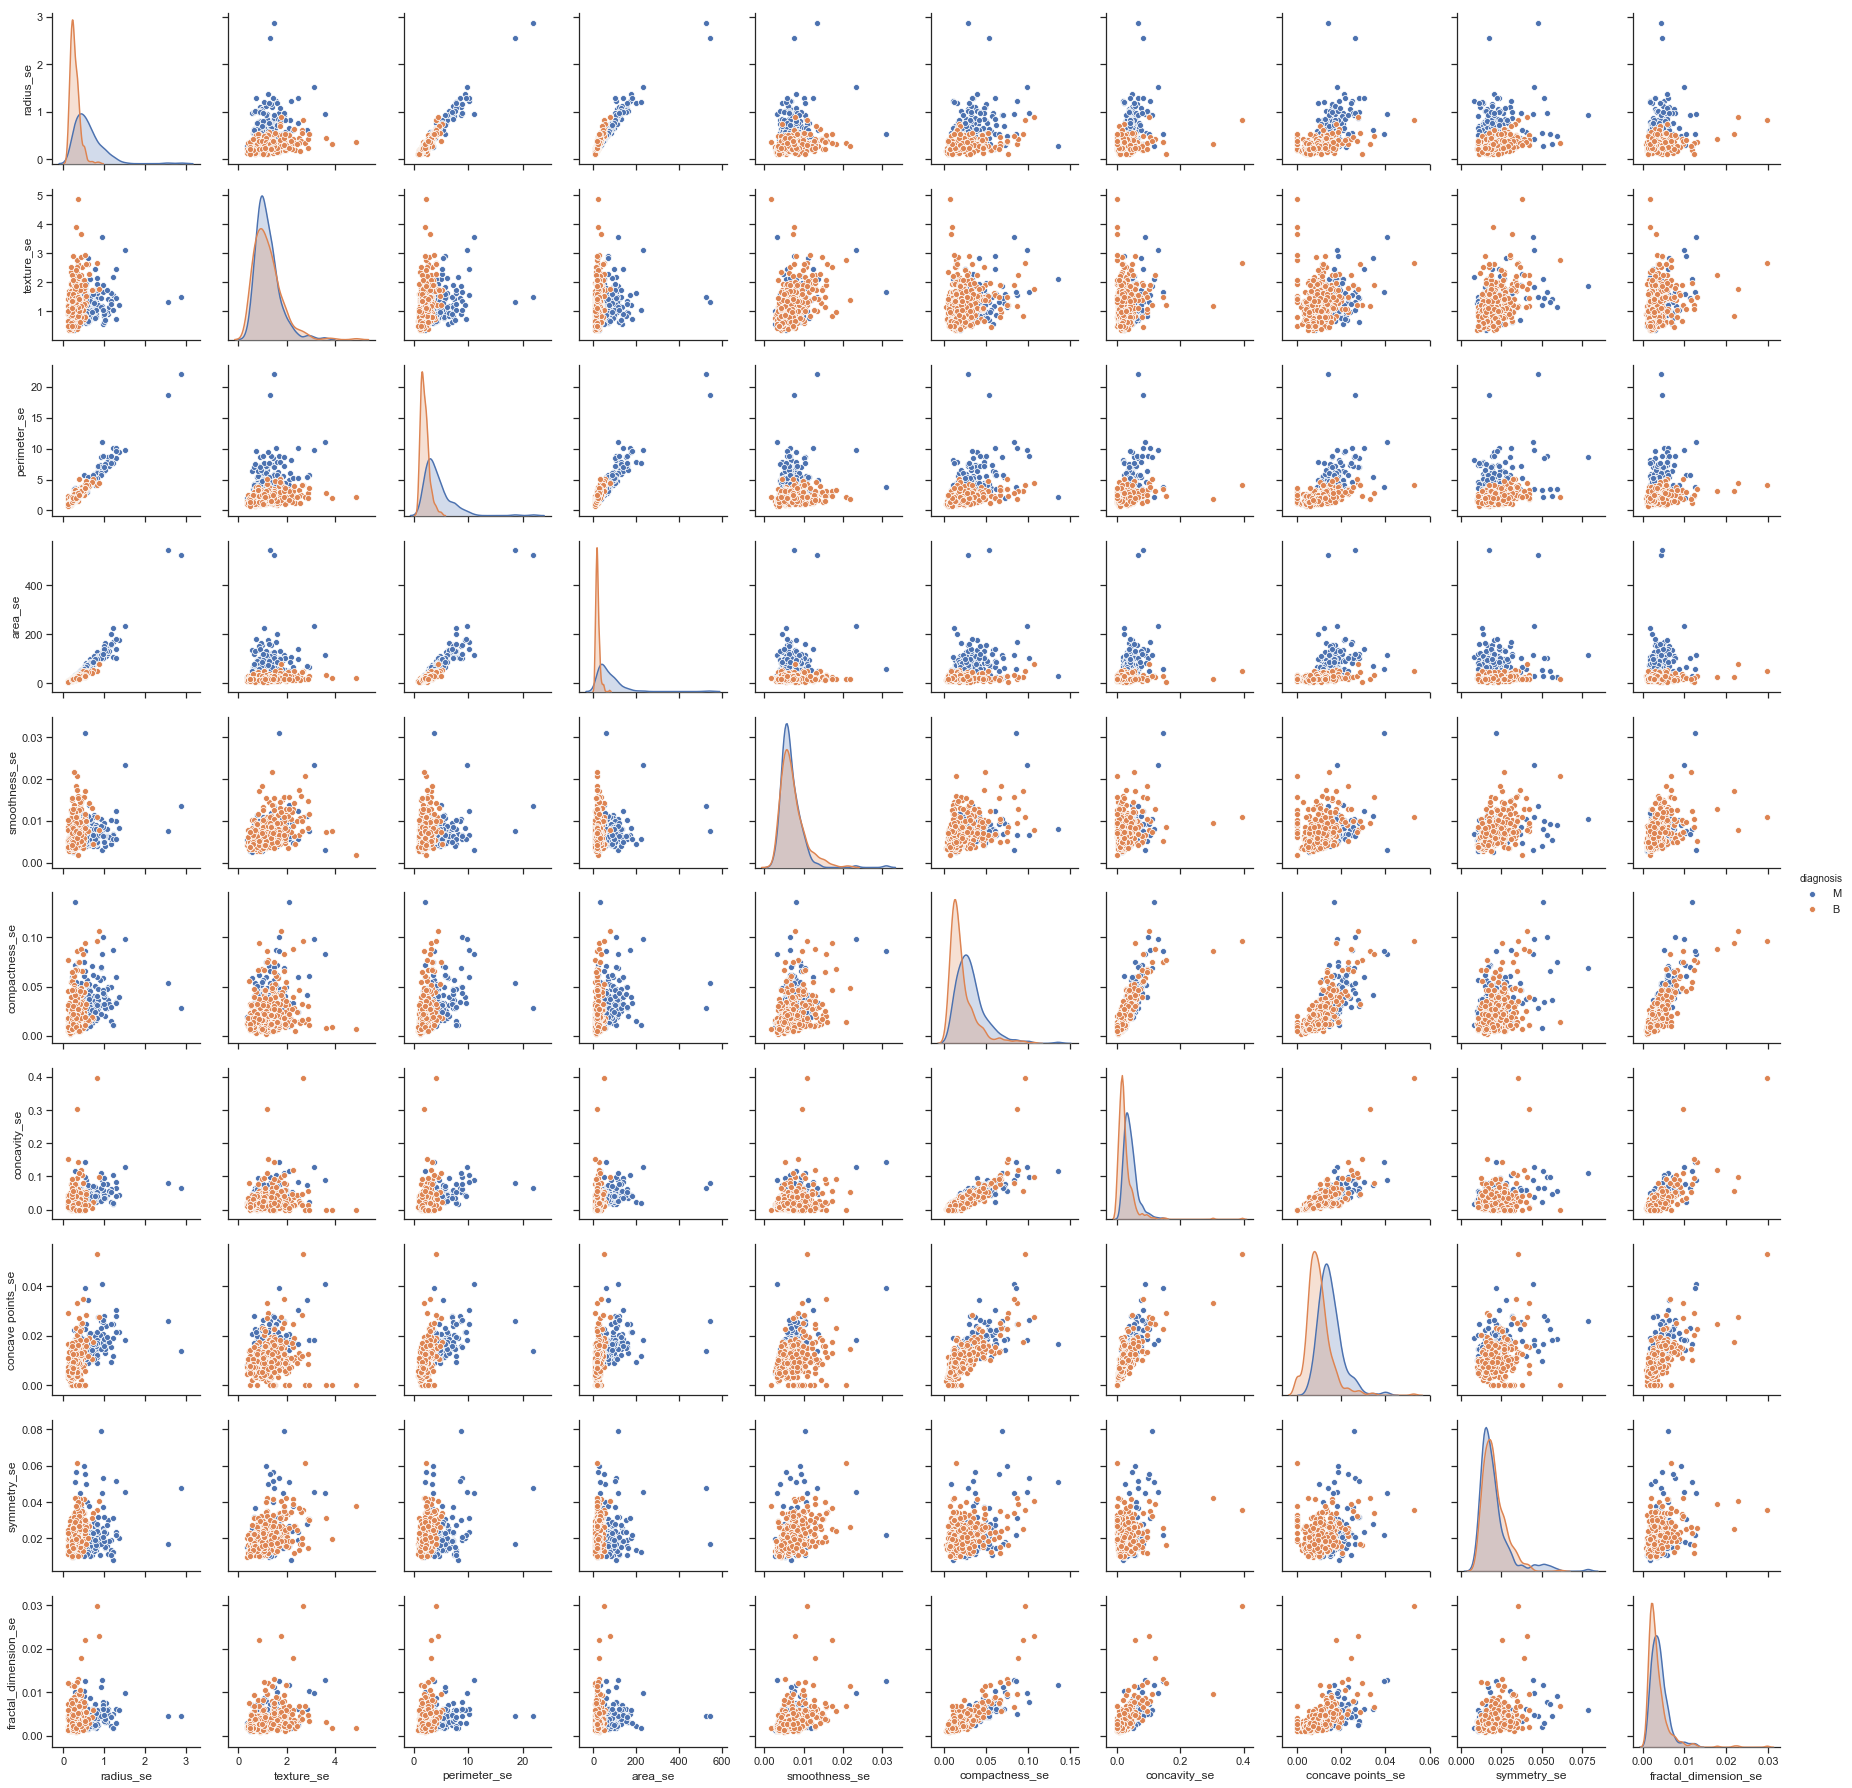

In [14]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=data[get_columns(["se"])], hue='diagnosis')
plt.show()

повторяем для для группы **worst**

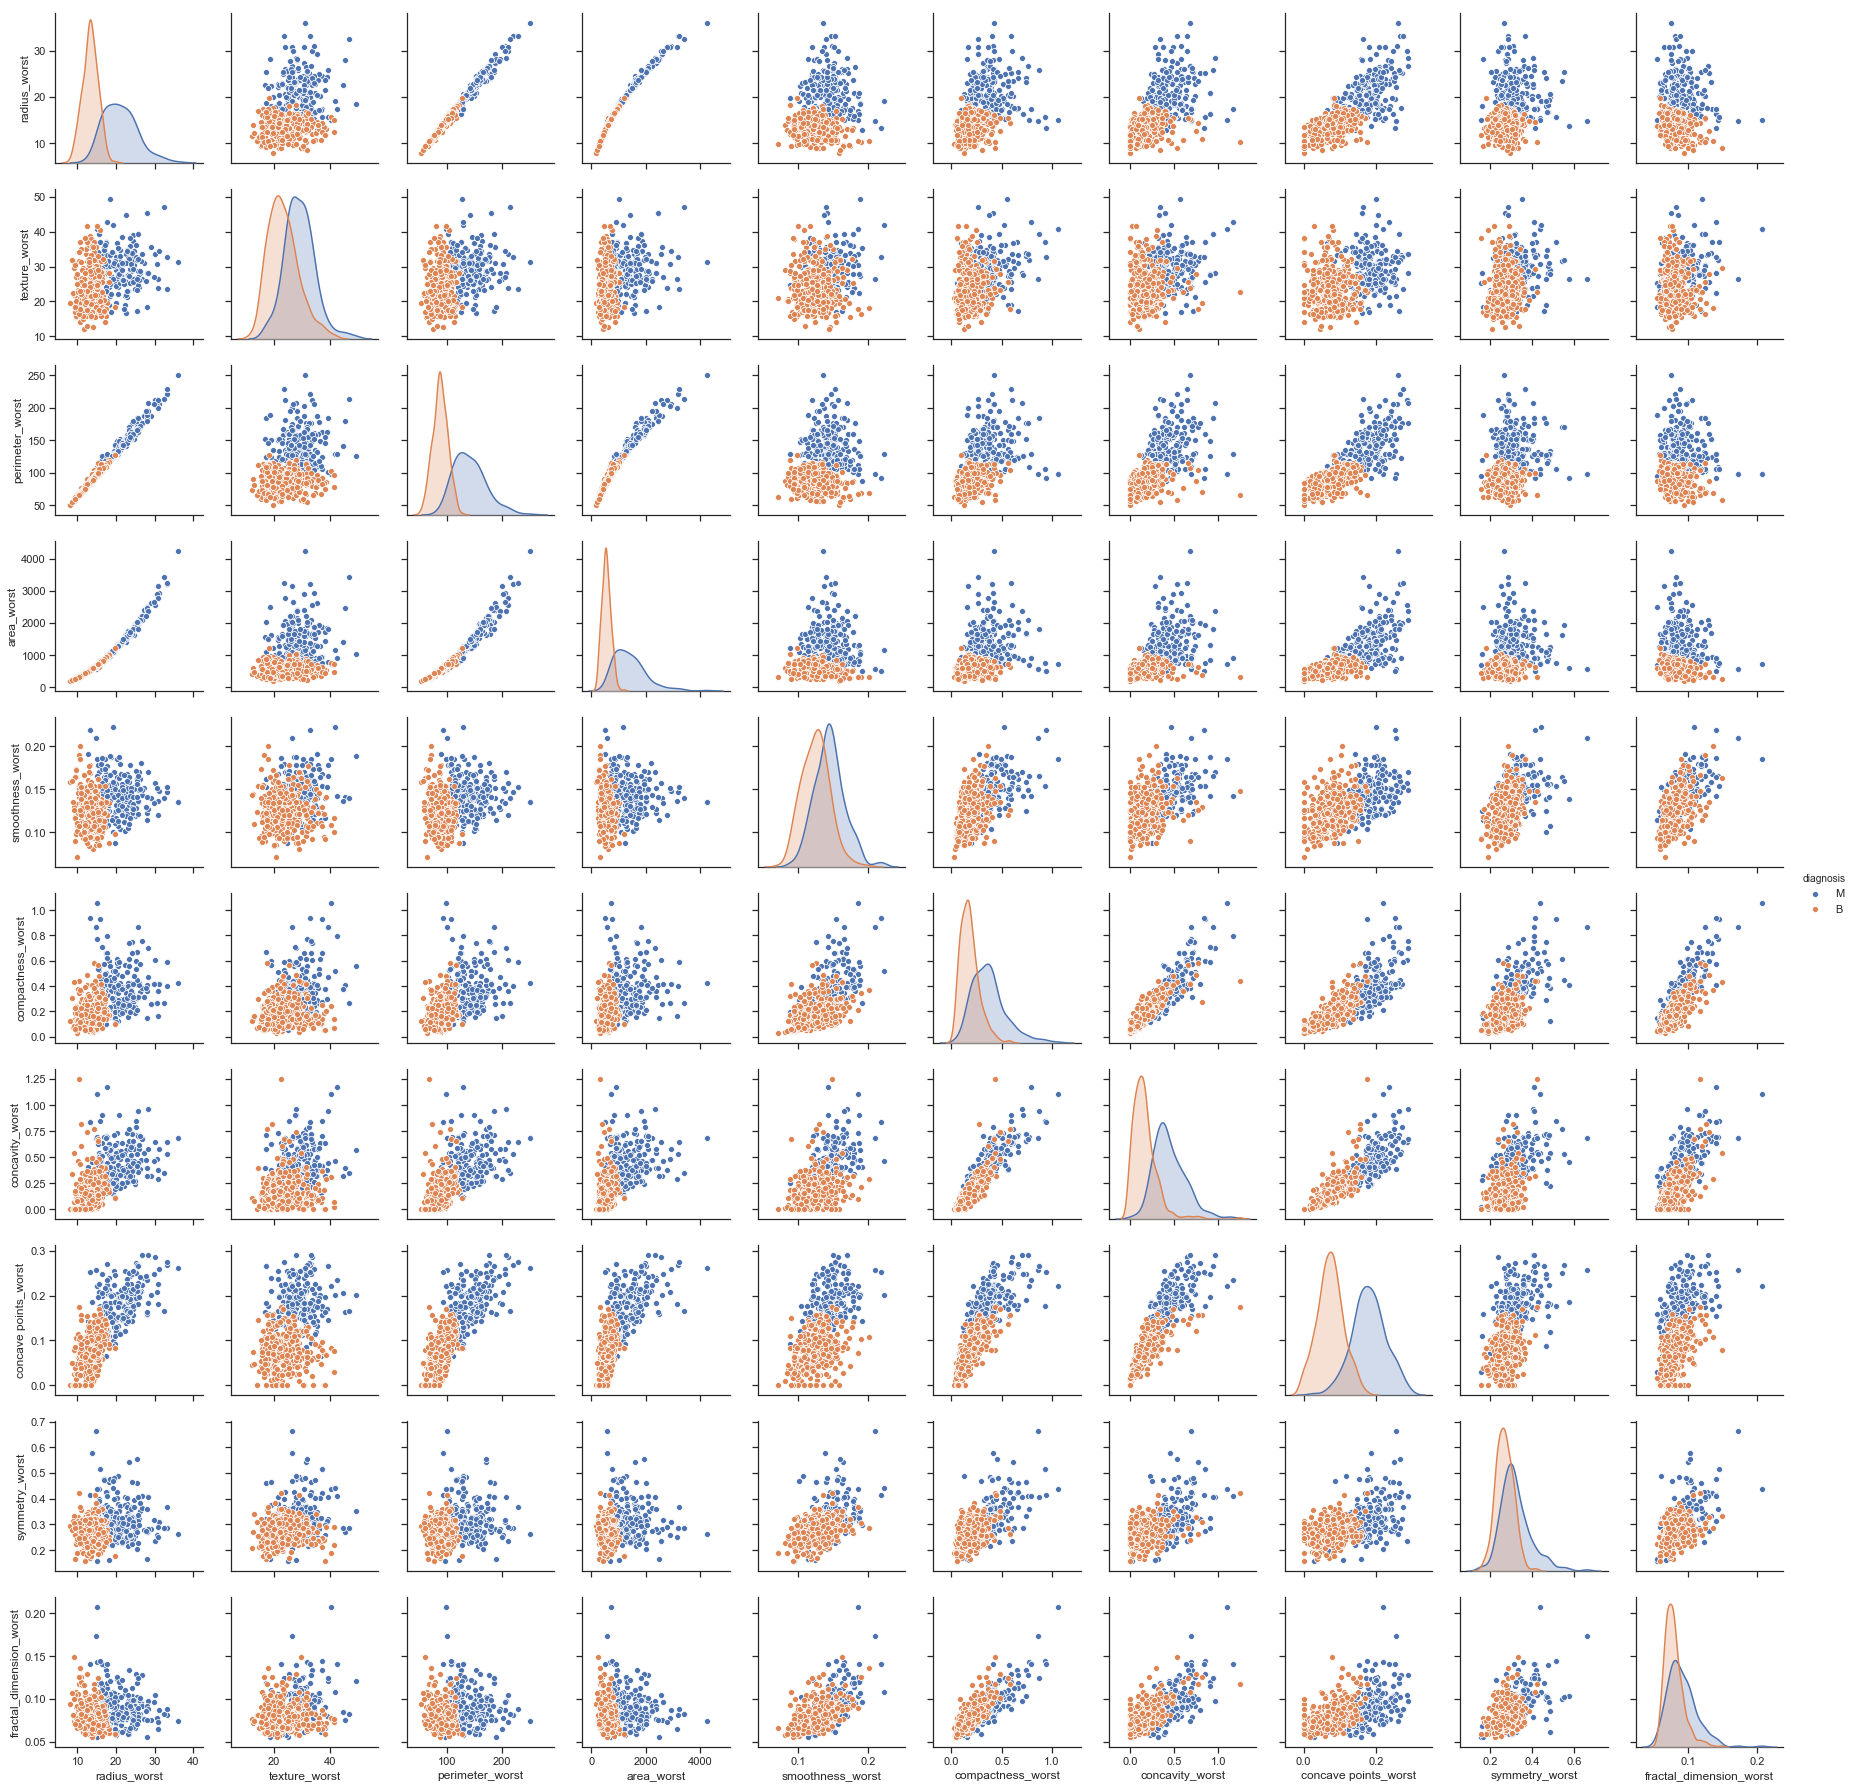

In [15]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=data[get_columns(["worst"])], hue='diagnosis')
plt.show()

- С помощью статистических методов проверить взаимосвязи между переменными.

По pairplot видно что группы M и B сильно кластеризуются, возьмем к примеру параметры area и compactness явно характеризующие размер клетки и применим к ним двухвыборочный t-критерий для независимых выборок. В качестве выборок будут служить групы M и B. За стандартную $\alpha$ примем уровень в 5%

In [16]:
benign_area_mean = data[data['diagnosis']=='B']['area_mean']
malicious_area_mean = data[data['diagnosis']=='M']['area_mean']

stats.ttest_ind(benign_area_mean, malicious_area_mean).pvalue

4.734564310307344e-88

Значение намного меньше 5% что говорит о статистическом различии параметра area_mean среди рассматриваемых групп 

In [17]:
benign_compactness_mean = data[data['diagnosis']=='B']['compactness_mean']
malicious_compactness_mean = data[data['diagnosis']=='M']['compactness_mean']

stats.ttest_ind(benign_compactness_mean, malicious_compactness_mean).pvalue

3.9382631058873895e-56

Значение намного меньше 5% что говорит о статистическом различии параметра compactness_mean среди рассматриваемых групп 

- Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих двух подходов даст лучший результат при классификации?

Генерация новых переменных в данном случае не понятно как делать, все фичи количественные, нет категориальных переменных (кроме целевой функции). Больше подходит сокращение размерности. В качестве стратегии feature selection берем Sequential Forward Selection

In [18]:
model_parameters = list(get_columns(["mean", "se", "worst"]))

Перекодируем целевую фичу в бинарный признак 0 - benign, 1 - malicious

In [19]:
diagnosis_tmp = data.diagnosis.apply(lambda x: 1 if x == 'M' else 0)
data["diagnosis"] = diagnosis_tmp
data.diagnosis.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

Удаляем ненужные столбцы

In [20]:
data.drop("id", axis=1,inplace=True)

- Рассчитать Feature Selection для выбранных переменных.

- Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2 алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и вывести вероятность каждого класса.

- Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall

В качестве алгоритмов регрессии выберем следующие алгоритмы LogisticRegression, RandomForestClassifier и RandomForestClassifier. Проверим также работу алгоритмов на различных в процентном соотношении разбиениях данных на train и test

In [21]:
def forward_selection(model, X, y) :
    skf = StratifiedKFold(n_splits=4)
    sfs_forward = SFS(model, 
                      k_features="best", 
                      forward=True, 
                      floating=False, 
                      verbose=0,
                      scoring='roc_auc',
                      cv=skf,
                      n_jobs=-1)
    
    sfs_forward = sfs_forward.fit(X.values, y.values, custom_feature_names=X.columns)
    
    X_sfs = sfs_forward.transform(X)
    model.fit(X_sfs, y)
    
    return list(sfs_forward.k_feature_names_)


In [22]:
splits_desc = [0.2, 0.5, 0.8]

models_desc = [
    (
        "Logistic Regression",
        LogisticRegression(random_state=42, solver='saga', multi_class='multinomial')
    ),
    (
        "Random Forest Classifier",
        RandomForestClassifier(n_jobs=-1)
    ),
    (
        "K Neighbors Classifier",
        KNeighborsClassifier(n_jobs=-1)
    )
]

statistics_desc = [
    ("accuracy", accuracy_score),
    ("f1 score", f1_score),
    ("precision", precision_score),
    ("recall", recall_score)
]

df_data = []

df_columns = ["total features", "mean features", "se features", "worst features", "spent time", *[s[0] for s in statistics_desc]]

for split in splits_desc:
    X = data.copy().drop('diagnosis', axis=1)
    y = data['diagnosis'].copy()
    data_train, data_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)

    for model in models_desc :
        df_data_item = []

        time_start = datetime.now()
        
        # запускаем отбор переменных с использованием текущего классификатора
        features = forward_selection(model[1], data_train, y_train)

        time_end = datetime.now()
        
        # записываем кол-во фичей
        df_data_item.append(len(features))
        
        #считаем кол-во используемых фичей из каждой из подгрупп mean, se и worst
        df_data_item.extend(
            [sum(x.endswith("_" + postfix) for x in features) for postfix in ["mean", "se", "worst"]]
        )
        
        # время работы алгоритма
        spent_time = humanfriendly.format_timespan(time_end - time_start)
        
        df_data_item.append(spent_time)
        
        
        # получаем по полученной модели предсказанные данные
        predict = model[1].predict(data_test[features])

        # считаем статистику
        df_data_item.extend([s[1](y_test, predict) for s in statistics_desc])

        df_data.append(df_data_item)
    

C:\Users\gvs\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gvs\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\gvs\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\gvs\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [23]:
pd.DataFrame(df_data, columns=df_columns,
             index=pd.MultiIndex.from_product([[model[0] for model in models_desc], splits_desc],
                                             names=["algorithm", "tests percent"]))

total features  mean features  \
algorithm                tests percent                                  
Logistic Regression      0.2                         7              2   
                         0.5                        10              2   
                         0.8                        21              8   
Random Forest Classifier 0.2                         9              4   
                         0.5                        23              8   
                         0.8                         7              1   
K Neighbors Classifier   0.2                        19              6   
                         0.5                         9              3   
                         0.8                        19              7   

                                        se features  worst features  \
algorithm                tests percent                                
Logistic Regression      0.2                      2               3   
                         0.5                      4               4   
                         0.8                      8               5   
Random Forest Classifier 0.2                      1               4   
                         0.5                      7               8   
                         0.8                      2               4   
K Neighbors Classifier   0.2                      6               7   
                         0.5                      2               4   
                         0.8                      9               3   

                                                        spent time  accuracy  \
algorithm                tests percent                                         
Logistic Regression      0.2                         20.84 seconds  0.798246   
                         0.5            1 minute and 38.74 seconds  0.956140   
                         0.8                          10.2 seconds  0.956140   
Random Forest Classifier 0.2                         12.98 seconds  0.768421   
                         0.5            1 minute and 30.12 seconds  0.975439   
                         0.8                            10 seconds  0.915789   
K Neighbors Classifier   0.2                          6.26 seconds  0.945175   
                         0.5            1 minute and 28.14 seconds  0.936404   
                         0.8                           9.8 seconds  0.918860   

                                        f1 score  precision    recall  
algorithm                tests percent                                 
Logistic Regression      0.2            0.634921   1.000000  0.465116  
                         0.5            0.941176   0.952381  0.930233  
                         0.8            0.939759   0.975000  0.906977  
Random Forest Classifier 0.2            0.748092   0.597561  1.000000  
                         0.5            0.964467   0.959596  0.969388  
                         0.8            0.880000   0.862745  0.897959  
K Neighbors Classifier   0.2            0.923547   0.937888  0.909639  
                         0.5            0.912387   0.915152  0.909639  
                         0.8            0.894587   0.848649  0.945783

Если брать за основу precision recall статистики то лучше всего работают алгоритмы на разбиении 50/50. Лучший результат выдает Random Forest Classifier

- Загрузить результат в формате .ipynb ноутбука в репозиторий, ссылку добавить в личный кабинет